# Multimodal Fusion Music Recommendation System

The purpose of this notebook is to perform the full data extraction, preprocessing, loading, and model pipeline.

In [107]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data Extraction

In [ ]:
# Install the required packages
%pip install -r requirements.txt

In [95]:
# Download the dataset
!bash download_dataset.sh

Directory 'data' already exists.
Starting download from: http://www.ee.columbia.edu/~thierry/artist_term.db
--2024-11-20 18:22:56--  http://www.ee.columbia.edu/~thierry/artist_term.db
Resolving www.ee.columbia.edu (www.ee.columbia.edu)... 162.159.128.65, 162.159.138.64
Connecting to www.ee.columbia.edu (www.ee.columbia.edu)|162.159.128.65|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.ee.columbia.edu/~thierry/artist_term.db [following]
--2024-11-20 18:22:56--  https://www.ee.columbia.edu/~thierry/artist_term.db
Connecting to www.ee.columbia.edu (www.ee.columbia.edu)|162.159.128.65|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 138974208 (133M)
Saving to: ‘data/artist_term.db’

data/artist_term.db 100%[===================>] 132.54M  9.12MB/s    in 15s     

2024-11-20 18:23:12 (8.72 MB/s) - ‘data/artist_term.db’ saved [138974208/138974208]

Download completed successfully. Saved as 'data/artist_term.db'.
S

## Preprocessing

In [158]:
from preprocessing.util.processor import Processor

Read data from databases/datasets, do some basic preprocessing, and save them as DataFrames serialized to pickle files.

In [159]:
processor = Processor(debug_messages=True)
processor.process()
processor.save_data()

Reading user listening history file: 48373586it [00:17, 2838733.69it/s]


Read 48373586 user triplets.
Reading mbtags from data/artist_term.db
Reading metadata from data/track_metadata.db
Database connected.
Columns in 'lyrics' table: ['track_id', 'mxm_tid', 'word', 'count', 'is_test', 'song_id']
'song_id' column already exists.
Lyrics table processed and pivoted with song_id as index.
Database connection closed.


## Loading

In [160]:
from models.data_provider import DataProvider

In [184]:
data_provider = DataProvider(
    label_embedding_technique='w2v',
    embedding_config={
        'vector_size': 100,
        'window': 5,
        'min_count': 1,
        'workers': 4,
        'sg': 1
    },
    save_embeddings_to_file=True,
    load_embeddings_from_file=True,
    clustering_method='kmeans',
    debug=True
)

In [185]:
data_provider.load_data()

Reading labels.
Reading tagged metadata.
Reading untagged metadata.
Reading lyrics.
Reading user data.


In [186]:
data_provider.generate_training_classes(cluster_config={'n_clusters': 10})

Generating training classes.
Reading label embedding dictionary from data/embeddings/label_embeddings/embedding_w2v.pkl.
Aggregating embeddings for all tracks.
Clustering mbtag_embedding.


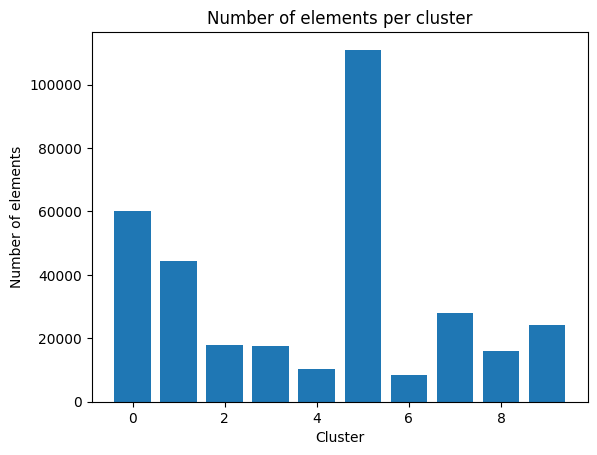

In [188]:
data_provider.plot_cluster_distribution()

In [179]:
data_provider.untagged_metadata_df.head()

,track_id,title,song_id,release,artist_id,artist_mbid,artist_name,duration,artist_familiarity,artist_hotttnesss,year,track_7digitalid,shs_perf,shs_work
0,TRMMMYQ128F932D901,Silent Night,SOQMMHC12AB0180CB8,Monster Ballads X-Mas,ARYZTJS1187B98C555,357ff05d-848a-44cf-b608-cb34b5701ae5,Faster Pussy cat,252.05506,0.649822,0.394032,2003,7032331,-1,0
1,TRMMMKD128F425225D,Tanssi vaan,SOVFVAK12A8C1350D9,Karkuteillä,ARMVN3U1187FB3A1EB,8d7ef530-a6fd-4f8f-b2e2-74aec765e0f9,Karkkiautomaatti,156.55138,0.439604,0.356992,1995,1514808,-1,0
2,TRMMMRX128F93187D9,No One Could Ever,SOGTUKN12AB017F4F1,Butter,ARGEKB01187FB50750,3d403d44-36ce-465c-ad43-ae877e65adc4,Hudson Mohawke,138.97098,0.643681,0.437504,2006,6945353,-1,0
3,TRMMMCH128F425532C,Si Vos Querés,SOBNYVR12A8C13558C,De Culo,ARNWYLR1187B9B2F9C,12be7648-7094-495f-90e6-df4189d68615,Yerba Brava,145.05751,0.448501,0.372349,2003,2168257,-1,0
4,TRMMMWA128F426B589,Tangle Of Aspens,SOHSBXH12A8C13B0DF,Rene Ablaze Presents Winter Sessions,AREQDTE1269FB37231,,Der Mystic,514.29832,0.000000,0.000000,0,2264873,-1,0


## Model

### Metadata Model

Generate an embedding vector for each song's metadata. This is done by creating an embedding for the song title, album title, and artist name, and concatenating them. Additional features such as release year, duration, an 'artist familiarity' rating, and 'artist hottness' rating are appended.

In [181]:
from models.metadata_model import MetadataModel

In [182]:
generic_w2v_encoder_config = {
    'embedding_technique': 'w2v',
    'aggregation_technique': 'mean',
    'load_from_file': False,
    'save_to_file': True,
    'vector_size': 100,
    'window': 5,
    'min_count': 1,
    'workers': 4,
    'sg': 1
}
metadata_model = MetadataModel(
    metadata_df=data_provider.tagged_metadata_df,
    configs={
        'title_encoder': generic_w2v_encoder_config,
        'release_encoder': generic_w2v_encoder_config,
        'artist_name_encoder': generic_w2v_encoder_config
    },
    debug=True
)

In [189]:
embeddings_df = metadata_model.get_metadata_embeddings()

In [262]:
from models.fusion import FusionStep
import numpy as np

In [302]:
fusion = FusionStep(
    fusion_method='min',
    debug=True,
)

In [303]:
fusion.load_components(
    [
        np.array(
            [[-10, -1,], [100, 2]]
        ),
        np.array(
            [[1, 20], [1, 3]]
        ),
    ]
)

In [304]:
fusion.fuse()
fusion.fused_vectors

array([[-10,  -1],
       [  1,   2]])